In [1]:
import pandas as pd

In [2]:
file_path = "DO NOT EDIT_ 2024 New Verticals Analytics Exercise (CANDIDATES - DO NOT EDIT, MAKE A COPY).xlsx"

# Skip the first row (0), start header at row 1
df = pd.read_excel(file_path, sheet_name="Dataset", header=1)


In [3]:
# Rename columns for Python since Excel sheet had a duplicate header row at the top which caused unnamed colmn names
df.columns = [
    "DELIVERY_UUID", "DELIV_CREATED_AT", "DELIV_STORE_NAME", "DELIV_DASHER_ID",
    "DELIV_SUBMARKET", "DELIV_D2R", "DELIV_IS_20_MIN_LATE", "DELIV_CLAT",
    "DELIV_CANCELLED_AT", "DELIV_MISSING_INCORRECT_REPORT", "WAS_REQUESTED",
    "WAS_MISSING", "WAS_SUBBED", "WAS_FOUND", "ITEM_NAME", "ITEM_PRICE_CENTS",
    "ITEM_CATEGORY", "SUBSTITUTE_ITEM_NAME", "SUBSTITUTE_ITEM_CATEGORY"
]

In [4]:
# Convert to datetime
df["DELIV_CREATED_AT"] = pd.to_datetime(df["DELIV_CREATED_AT"])
df["DELIV_CANCELLED_AT"] = pd.to_datetime(df["DELIV_CANCELLED_AT"], errors="coerce")

# Convert to numeric
num_cols = ["DELIV_D2R", "DELIV_CLAT", "DELIV_IS_20_MIN_LATE",
            "WAS_REQUESTED", "WAS_MISSING", "WAS_SUBBED", "WAS_FOUND"]

df[num_cols] = df[num_cols].apply(pd.to_numeric, errors="coerce")

In [5]:
print(df.shape)     # check rows and columns
print(df.dtypes)    # check column types
print(df.head())    # check first 5 rows

(60583, 19)
DELIVERY_UUID                             object
DELIV_CREATED_AT                  datetime64[ns]
DELIV_STORE_NAME                          object
DELIV_DASHER_ID                          float64
DELIV_SUBMARKET                           object
DELIV_D2R                                float64
DELIV_IS_20_MIN_LATE                     float64
DELIV_CLAT                               float64
DELIV_CANCELLED_AT                datetime64[ns]
DELIV_MISSING_INCORRECT_REPORT              bool
WAS_REQUESTED                            float64
WAS_MISSING                              float64
WAS_SUBBED                               float64
WAS_FOUND                                float64
ITEM_NAME                                 object
ITEM_PRICE_CENTS                         float64
ITEM_CATEGORY                             object
SUBSTITUTE_ITEM_NAME                      object
SUBSTITUTE_ITEM_CATEGORY                  object
dtype: object
                          DELIVERY_UUID    

In [6]:
df["DELIVERY_UUID"].nunique()   # unique deliveries (~13,085)
df.shape[0]                     # total rows (~60,583 items)

60583

In [7]:
# since the data is in item level(per person per item), we want to aggregate to delivery level(per person per order) based on the same DELIVERY_UUID to calculate KPIs 
# in this way, we avoid duplicates 

delivery_agg = (
    df.groupby("DELIVERY_UUID")
      .agg(
          DELIV_CREATED_AT=("DELIV_CREATED_AT","min"),   # first item timestamp
          DELIV_STORE_NAME=("DELIV_STORE_NAME","first"), # store
          DELIV_SUBMARKET=("DELIV_SUBMARKET","first"),   # submarket
          DELIV_D2R=("DELIV_D2R","mean"),                # avg time dasher to store
          DELIV_CLAT=("DELIV_CLAT","mean"),              # avg acceptance time
          DELIV_IS_20_MIN_LATE=("DELIV_IS_20_MIN_LATE","max"), # 1 if any item late
          DELIV_CANCELLED=("DELIV_CANCELLED_AT", lambda s: int(s.notna().any())),
          DELIV_MISSING_INCORRECT_REPORT=("DELIV_MISSING_INCORRECT_REPORT", lambda s: int(s.astype(bool).any())),
          items_requested=("WAS_REQUESTED","sum"),
          items_missing=("WAS_MISSING","sum"),
          items_subbed=("WAS_SUBBED","sum"),
          items_found=("WAS_FOUND","sum"),
          basket_value=("ITEM_PRICE_CENTS","sum")
      )
      .reset_index()
)


In [8]:
# we actually have 13085 unique deliveries after aggregation
print(delivery_agg.shape)
delivery_agg.head()

(13085, 14)


,DELIVERY_UUID,DELIV_CREATED_AT,DELIV_STORE_NAME,DELIV_SUBMARKET,DELIV_D2R,DELIV_CLAT,DELIV_IS_20_MIN_LATE,DELIV_CANCELLED,DELIV_MISSING_INCORRECT_REPORT,items_requested,items_missing,items_subbed,items_found,basket_value
0,000b3220-d3c4-47f9-8e84-b072ebc2298c,2022-10-03 04:08:19,DashMart1,Cincinnati,0.050000,2.133333,0.0,0,0,8.0,1.0,1.0,7.0,26.22
1,0011f3fa-8458-4448-809a-c1a7204d77b3,2022-10-03 01:59:03,DashMart1,Cincinnati,2.033333,1.516667,0.0,0,0,6.0,0.0,0.0,6.0,21.54
2,0012e0a2-efb5-4f24-88df-32e4cc089bb4,2022-10-10 01:58:07,DashMart1,Cincinnati,0.083333,2.433333,0.0,0,0,1.0,0.0,0.0,1.0,2.49
3,001bf161-b895-4621-9747-f715e6c10898,2022-10-07 20:56:08,DashMart1,Cincinnati,0.033333,0.266667,0.0,0,0,1.0,0.0,0.0,1.0,22.49
4,0024913d-12e5-4b1b-b7bf-3ad09fa227bf,2022-10-03 12:17:52,Grocery1,Cincinnati,1.950000,0.183333,0.0,0,0,4.0,0.0,0.0,4.0,15.25


In [9]:
avg_items = delivery_agg["items_requested"].mean()   # ~4.63 items/delivery
avg_value = delivery_agg["basket_value"].mean()      # ~$23 average basket
avg_late_time = delivery_agg["DELIV_IS_20_MIN_LATE"].mean()  # ~0.048 = 4.8% late

print(avg_items, avg_value, avg_late_time)

4.629957967137944 23.007811998471443 0.04829957967137944


In [10]:
# calculate important KPIs based on deliveries 
metrics = {
    "unique_deliveries": delivery_agg.shape[0],
    "avg_items_per_delivery": delivery_agg["items_requested"].mean(),
    "avg_basket_value": delivery_agg["basket_value"].mean(),
    "late_rate": delivery_agg["DELIV_IS_20_MIN_LATE"].mean(),
    "cancel_rate": delivery_agg["DELIV_CANCELLED"].mean(),
    "complaint_rate": delivery_agg["DELIV_MISSING_INCORRECT_REPORT"].mean()
}
print(metrics)

{'unique_deliveries': 13085, 'avg_items_per_delivery': 4.629957967137944, 'avg_basket_value': 23.007811998471443, 'late_rate': 0.04829957967137944, 'cancel_rate': 0.015666794038975928, 'complaint_rate': 0.015896064195643867}


In [11]:
# --- Step 1: Create value segments (equal tertiles) ---
delivery_agg["value_segment"] = pd.qcut(
    delivery_agg["basket_value"],
    q=[0, 1/3, 2/3, 1],
    labels=["Low", "Medium", "High"],
    duplicates="drop"
)

# --- Step 2: Ensure flags are numeric ---
for col in ["DELIV_IS_20_MIN_LATE", "DELIV_MISSING_INCORRECT_REPORT"]:
    delivery_agg[col] = delivery_agg[col].astype(int)

delivery_agg["was_cancelled"] = delivery_agg["DELIV_CANCELLED"].astype(int)

# --- Step 3: Aggregate KPIs by segment ---
seg_summary = (
    delivery_agg.groupby("value_segment")
    .agg(
        orders=("DELIVERY_UUID", "count"),
        avg_basket_value=("basket_value", "mean"),
        cancellation_rate=("was_cancelled", "mean"),
        complaint_rate=("DELIV_MISSING_INCORRECT_REPORT", "mean"),
        late_rate=("DELIV_IS_20_MIN_LATE", "mean")
    )
    .reset_index()
)

# Convert to percentages
for c in ["cancellation_rate", "complaint_rate", "late_rate"]:
    seg_summary[c] = (seg_summary[c] * 100).round(2)
seg_summary["avg_basket_value"] = seg_summary["avg_basket_value"].round(2)

print(seg_summary)

# --- Step 4: Plot chart ---
x = np.arange(len(seg_summary))  # Low, Medium, High
width = 0.25

fig, ax = plt.subplots(figsize=(8,6))

bars1 = ax.bar(x - width, seg_summary["cancellation_rate"], width, label="Cancellation")
bars2 = ax.bar(x, seg_summary["complaint_rate"], width, label="Complaint")
bars3 = ax.bar(x + width, seg_summary["late_rate"], width, label="Late")

ax.set_xticks(x)
ax.set_xticklabels(seg_summary["value_segment"])
ax.set_ylabel("Rate (%)")
ax.set_title("Cancellation, Complaint, and Late Rates by Customer Segment")
ax.legend()

# Annotate values on bars
def annotate(bars):
    for b in bars:
        h = b.get_height()
        ax.text(b.get_x() + b.get_width()/2, h + 0.2, f"{h:.2f}%", ha="center", va="bottom", fontsize=9)

annotate(bars1)
annotate(bars2)
annotate(bars3)

plt.tight_layout()
plt.show()


  value_segment  orders  avg_basket_value  cancellation_rate  complaint_rate  \
0           Low    4373              9.01               2.38            0.73   
1        Medium    4353             18.00               1.54            1.08   
2          High    4359             42.05               0.78            2.96   

   late_rate  
0       4.76  
1       4.39  
2       5.35  


NameError: name 'np' is not defined

In [12]:
# Deep dive into causation behind late 
late = delivery_agg[delivery_agg["DELIV_IS_20_MIN_LATE"] == 1]
ontime = delivery_agg[delivery_agg["DELIV_IS_20_MIN_LATE"] == 0]

In [13]:
#look at CLAT, D2R, items, basket value, complaints, cancels.
late_on_time_summary = pd.DataFrame({
    "group": ["On-time", "Late"],
    "n_deliveries": [len(ontime), len(late)],
    "avg_D2R_min": [ontime["DELIV_D2R"].mean(), late["DELIV_D2R"].mean()],
    "avg_CLAT_min": [ontime["DELIV_CLAT"].mean(), late["DELIV_CLAT"].mean()],
    "avg_items": [ontime["items_requested"].mean(), late["items_requested"].mean()],
    "avg_basket_$": [ontime["basket_value"].mean(), late["basket_value"].mean()],
    "complaint_rate": [ontime["DELIV_MISSING_INCORRECT_REPORT"].mean(), late["DELIV_MISSING_INCORRECT_REPORT"].mean()],
    "cancel_rate": [ontime["DELIV_CANCELLED"].mean(), late["DELIV_CANCELLED"].mean()],
})
late_on_time_summary

,group,n_deliveries,avg_D2R_min,avg_CLAT_min,avg_items,avg_basket_$,complaint_rate,cancel_rate
0,On-time,12453,3.706872,4.179306,4.634225,22.96246,0.015097,0.016462
1,Late,632,8.509701,19.243800,4.545886,23.90144,0.031646,0.000000


In [14]:
# Check Correlation
delivery_agg[["DELIV_D2R", "DELIV_CLAT", "DELIV_IS_20_MIN_LATE"]].corr()

,DELIV_D2R,DELIV_CLAT,DELIV_IS_20_MIN_LATE
DELIV_D2R,1.000000,0.040308,0.071465
DELIV_CLAT,0.040308,1.000000,0.412187
DELIV_IS_20_MIN_LATE,0.071465,0.412187,1.000000


In [15]:
delivery_agg[["DELIV_IS_20_MIN_LATE",  "DELIV_CANCELLED", "DELIV_MISSING_INCORRECT_REPORT"]].corr()

,DELIV_IS_20_MIN_LATE,DELIV_CANCELLED,DELIV_MISSING_INCORRECT_REPORT
DELIV_IS_20_MIN_LATE,1.000000,-0.028421,0.028368
DELIV_CANCELLED,-0.028421,1.000000,-0.016034
DELIV_MISSING_INCORRECT_REPORT,0.028368,-0.016034,1.000000


In [16]:
# complaint rates for on-time vs late
complaint_rate_ontime = ontime["DELIV_MISSING_INCORRECT_REPORT"].mean()
complaint_rate_late   = late["DELIV_MISSING_INCORRECT_REPORT"].mean()
print(complaint_rate_ontime, complaint_rate_late)

0.015096763832008352 0.03164556962025317


In [17]:
import matplotlib.pyplot as plt
import numpy as np

In [18]:
# ---------- 1) On-time vs Late: avg CLAT & avg D2R ----------
on_time_vs_late = (
    delivery_agg
      .groupby("DELIV_IS_20_MIN_LATE", as_index=False)
      .agg(
          deliveries=("DELIVERY_UUID", "count"),
          avg_clat=("DELIV_CLAT", "mean"),
          avg_d2r=("DELIV_D2R", "mean")
      )
      .assign(status=lambda d: d["DELIV_IS_20_MIN_LATE"].map({0: "On time", 1: "Late"}))
      .drop(columns="DELIV_IS_20_MIN_LATE")
      .loc[:, ["status","deliveries","avg_clat","avg_d2r"]]
)

# Optional: round for neat display
on_time_vs_late["avg_clat"] = on_time_vs_late["avg_clat"].round(2)
on_time_vs_late["avg_d2r"] = on_time_vs_late["avg_d2r"].round(2)
print("Avg CLAT & D2R by delivery status")
print(on_time_vs_late.to_string(index=False))

# ---------- 2) For late deliveries: are missing rates high as well? ----------
# Define missing metrics
delivery_agg = delivery_agg.copy()
delivery_agg["has_missing_item"] = (delivery_agg["items_missing"] > 0).astype(int)

missing_summary = (
    delivery_agg
      .groupby("DELIV_IS_20_MIN_LATE")
      .agg(
          deliveries=("DELIVERY_UUID", "count"),
          # delivery-level: share of deliveries with ≥1 missing item
          missing_delivery_rate=("has_missing_item", "mean"),
          # item-level: proportion of missing items out of requested items
          items_missing=("items_missing", "sum"),
          items_requested=("items_requested", "sum"),
          # (optional) complaint rate for context
          complaint_rate=("DELIV_MISSING_INCORRECT_REPORT","mean")
      )
      .reset_index()
      .assign(
          status=lambda d: d["DELIV_IS_20_MIN_LATE"].map({0:"On time", 1:"Late"}),
          item_missing_rate=lambda d: d["items_missing"] / d["items_requested"]
      )
      .loc[:, ["status","deliveries","missing_delivery_rate","item_missing_rate","complaint_rate"]]
)

# Format as percentages
for c in ["missing_delivery_rate", "item_missing_rate", "complaint_rate"]:
    missing_summary[c] = (missing_summary[c] * 100).round(2)

print("\nMissing rates (delivery-level and item-level) by status")
print(missing_summary.to_string(index=False))

Avg CLAT & D2R by delivery status
 status  deliveries  avg_clat  avg_d2r
On time       12453      4.18     3.71
   Late         632     19.24     8.51

Missing rates (delivery-level and item-level) by status
 status  deliveries  missing_delivery_rate  item_missing_rate  complaint_rate
On time       12453                  16.87               6.23            1.51
   Late         632                  14.72               6.58            3.16


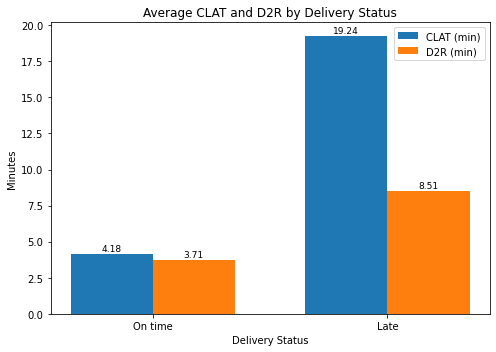

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Expecting a DataFrame like this from earlier steps:
# on_time_vs_late columns: ["status","deliveries","avg_clat","avg_d2r"]
# If yours is ["avg_CLAT","avg_D2R"], this rename keeps things consistent:
on_time_vs_late = on_time_vs_late.rename(columns={
    "avg_CLAT": "avg_clat",
    "avg_D2R": "avg_d2r",
    "Status": "status"
})

# Ensure ordering: On time, Late
order = ["On time", "Late"]
plot_df = on_time_vs_late.set_index("status").loc[order].reset_index()

x = np.arange(len(plot_df))     # positions for groups
width = 0.35                    # bar width

fig, ax = plt.subplots(figsize=(7,5))

bar1 = ax.bar(x - width/2, plot_df["avg_clat"], width, label="CLAT (min)")
bar2 = ax.bar(x + width/2, plot_df["avg_d2r"], width, label="D2R (min)")

ax.set_xticks(x)
ax.set_xticklabels(plot_df["status"])
ax.set_xlabel("Delivery Status")
ax.set_ylabel("Minutes")
ax.set_title("Average CLAT and D2R by Delivery Status")
ax.legend()

# annotate bars
def annotate(bars):
    for b in bars:
        h = b.get_height()
        ax.text(b.get_x() + b.get_width()/2, h + 0.05, f"{h:.2f}", ha="center", va="bottom", fontsize=9)

annotate(bar1)
annotate(bar2)

plt.tight_layout()
plt.show()


    hour  deliveries  dashers  late_rate  deliv_per_dasher
0      0        1231      500       4.06          2.462000
1      1        1148      443       3.75          2.591422
2      2        1105      373       3.35          2.962466
3      3         838      253       8.83          3.312253
4      4         597      204       6.53          2.926471
5      5         328      146       6.40          2.246575
6      6          12       12      16.67          1.000000
7      7           7        6       0.00          1.166667
8      8           7        6      14.29          1.166667
9      9          19       18      10.53          1.055556
10    10          42       33       7.14          1.272727
11    11         110       78       5.45          1.410256
12    12         296      165       3.04          1.793939
13    13         382      234       4.19          1.632479
14    14         470      268       4.26          1.753731
15    15         447      257       3.36          1.7393

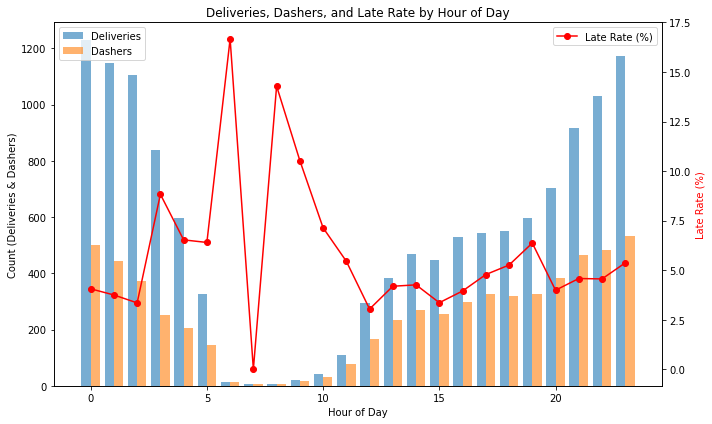

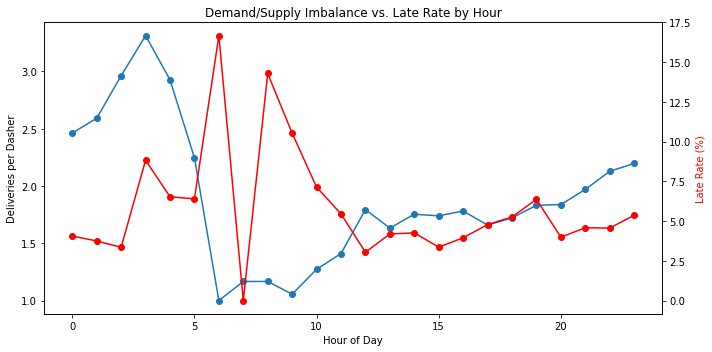

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# --- 0) Build a delivery-level table from the item-level df ---
# (one row per DELIVERY_UUID with its dasher, created_at, lateness, etc.)
delivery_level = (
    df.groupby("DELIVERY_UUID", as_index=False)
      .agg(
          DELIV_CREATED_AT=("DELIV_CREATED_AT", "min"),
          DELIV_DASHER_ID=("DELIV_DASHER_ID", "first"),
          DELIV_IS_20_MIN_LATE=("DELIV_IS_20_MIN_LATE", "max")  # 1 if any item says late
      )
)

# If your timestamps aren't datetime yet, ensure it:
delivery_level["DELIV_CREATED_AT"] = pd.to_datetime(delivery_level["DELIV_CREATED_AT"], errors="coerce")

# --- 1) Extract hour and aggregate by hour ---
delivery_level["hour"] = delivery_level["DELIV_CREATED_AT"].dt.hour

hourly_summary = (
    delivery_level.groupby("hour", as_index=False)
      .agg(
          deliveries=("DELIVERY_UUID", "count"),
          dashers=("DELIV_DASHER_ID", "nunique"),
          late_rate=("DELIV_IS_20_MIN_LATE", "mean")
      )
)

# Derived metric: supply/demand balance
hourly_summary["deliv_per_dasher"] = (
    hourly_summary["deliveries"] / hourly_summary["dashers"].replace(0, pd.NA)
)

# Formatting
hourly_summary["late_rate"] = (hourly_summary["late_rate"] * 100).round(2)

print(hourly_summary.sort_values("hour"))

# --- 2) (Optional) Plot deliveries, dashers, late rate ---
fig, ax1 = plt.subplots(figsize=(10,6))
ax1.bar(hourly_summary["hour"]-0.2, hourly_summary["deliveries"], width=0.4, alpha=0.6, label="Deliveries")
ax1.bar(hourly_summary["hour"]+0.2, hourly_summary["dashers"], width=0.4, alpha=0.6, label="Dashers")
ax1.set_xlabel("Hour of Day")
ax1.set_ylabel("Count (Deliveries & Dashers)")
ax1.legend(loc="upper left")

ax2 = ax1.twinx()
ax2.plot(hourly_summary["hour"], hourly_summary["late_rate"], marker="o", label="Late Rate (%)", color="red")
ax2.set_ylabel("Late Rate (%)", color="red")
ax2.legend(loc="upper right")
plt.title("Deliveries, Dashers, and Late Rate by Hour of Day")
plt.tight_layout()
plt.show()

# --- 3) (Optional) Plot deliveries-per-dasher vs late rate (direct imbalance view) ---
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(hourly_summary["hour"], hourly_summary["deliv_per_dasher"], marker="o", label="Deliveries per Dasher")
ax.set_xlabel("Hour of Day")
ax.set_ylabel("Deliveries per Dasher")
ax2 = ax.twinx()
ax2.plot(hourly_summary["hour"], hourly_summary["late_rate"], marker="o", color="red", label="Late Rate (%)")
ax2.set_ylabel("Late Rate (%)", color="red")
plt.title("Demand/Supply Imbalance vs. Late Rate by Hour")
plt.tight_layout()
plt.show()


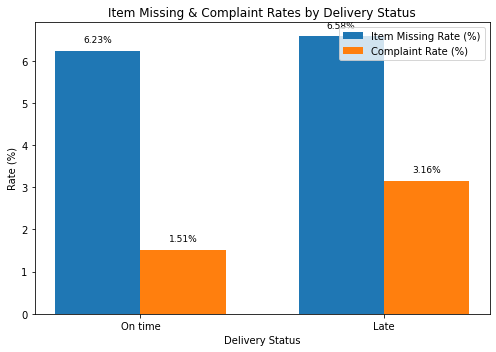

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# Using your existing DataFrame "missing_summary"
# Keep only the two relevant metrics
metrics = ["item_missing_rate", "complaint_rate"]
labels = ["Item Missing Rate (%)", "Complaint Rate (%)"]

x = np.arange(len(missing_summary["status"]))  # On time, Late
width = 0.35  # width of each bar

fig, ax = plt.subplots(figsize=(7,5))

# Plot bars
for i, metric in enumerate(metrics):
    ax.bar(x + i*width, missing_summary[metric], width, label=labels[i])

# Formatting
ax.set_xticks(x + width/2)
ax.set_xticklabels(missing_summary["status"])
ax.set_xlabel("Delivery Status")
ax.set_ylabel("Rate (%)")
ax.set_title("Item Missing & Complaint Rates by Delivery Status")
ax.legend()

# Annotate values
for i, metric in enumerate(metrics):
    for j, val in enumerate(missing_summary[metric]):
        ax.text(j + i*width, val + 0.2, f"{val:.2f}%", ha="center", fontsize=9)

plt.tight_layout()
plt.show()


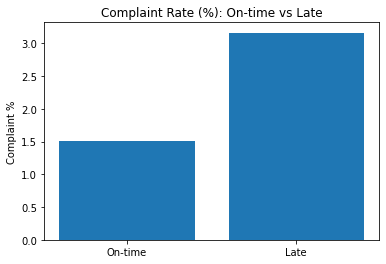

In [33]:
# complaint rate chart
plt.bar(late_on_time_summary["group"], late_on_time_summary["complaint_rate"]*100)
plt.title("Complaint Rate (%): On-time vs Late")
plt.ylabel("Complaint %")
plt.show()


In [34]:
# Group by Store level to investigate 
store_metrics = (
    delivery_agg.groupby("DELIV_STORE_NAME")
      .agg(
          deliveries=("DELIVERY_UUID","count"),
          late_rate=("DELIV_IS_20_MIN_LATE","mean"),
          cancel_rate=("DELIV_CANCELLED","mean"),
          complaint_rate=("DELIV_MISSING_INCORRECT_REPORT","mean"),
          avg_D2R=("DELIV_D2R","mean"),
          avg_CLAT=("DELIV_CLAT","mean"),
          avg_items=("items_requested","mean"),
          avg_basket_value=("basket_value","mean")
      )
      .sort_values("deliveries", ascending=False)
)
store_metrics

,deliveries,late_rate,cancel_rate,complaint_rate,avg_D2R,avg_CLAT,avg_items,avg_basket_value
DELIV_STORE_NAME,,,,,,,,
DashMart1,9018,0.054779,0.011200,0.010202,3.081564,4.878338,3.808938,18.241765
Grocery1,2736,0.027412,0.023757,0.031067,4.802452,4.499256,6.478801,33.398026
Grocery2,1143,0.054243,0.031496,0.027122,8.065401,5.906849,6.591426,34.156938
Grocery3,188,0.005319,0.015957,0.000000,7.058649,3.896276,5.180851,32.630851


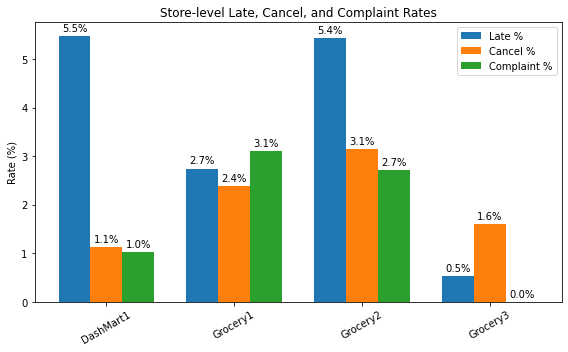

In [35]:
# Store level Comparison
# Convert to % for readability
store_metrics_pct = store_metrics * 100

# Plot grouped bars
x = np.arange(len(store_metrics_pct))  # store positions
width = 0.25

fig, ax = plt.subplots(figsize=(8,5))
rects1 = ax.bar(x - width, store_metrics_pct["late_rate"], width, label="Late %")
rects2 = ax.bar(x, store_metrics_pct["cancel_rate"], width, label="Cancel %")
rects3 = ax.bar(x + width, store_metrics_pct["complaint_rate"], width, label="Complaint %")

# Labels
ax.set_ylabel("Rate (%)")
ax.set_title("Store-level Late, Cancel, and Complaint Rates")
ax.set_xticks(x)
ax.set_xticklabels(store_metrics_pct.index, rotation=30)
ax.legend()

# Annotate values
for rect in rects1 + rects2 + rects3:
    height = rect.get_height()
    ax.annotate(f"{height:.1f}%",
                xy=(rect.get_x() + rect.get_width()/2, height),
                xytext=(0,3), textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.show()


  DELIV_STORE_NAME  deliveries  delivery_share  found_rate  missing_rate  \
0        DashMart1        9018       68.918609    0.994061      0.002271   
1         Grocery1        2736       20.909438    0.844917      0.147805   
2         Grocery2        1143        8.735193    0.865012      0.127688   
3         Grocery3         188        1.436760    0.870637      0.129363   

   substitution_rate  
0           0.001106  
1           0.102505  
2           0.087205  
3           0.078029  


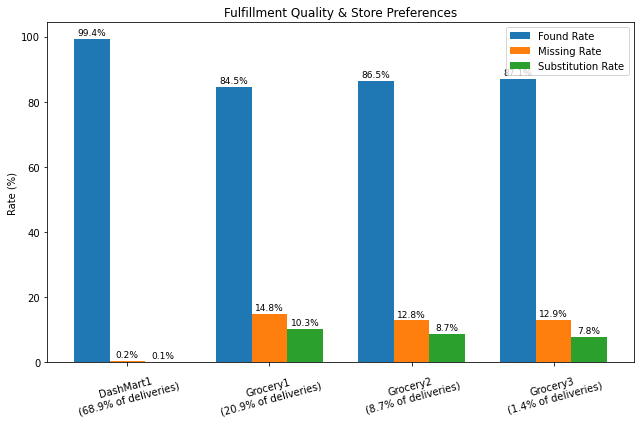

In [36]:
import matplotlib.pyplot as plt

# --- Step 1: Store-level metrics ---
store_summary = (
    df.groupby("DELIV_STORE_NAME")
      .agg(
          deliveries=("DELIVERY_UUID","nunique"),   # number of unique deliveries
          items_requested=("WAS_REQUESTED", "sum"),
          items_found=("WAS_FOUND", "sum"),
          items_missing=("WAS_MISSING", "sum"),
          items_subbed=("WAS_SUBBED", "sum")
      )
      .reset_index()
)

# Calculate rates
store_summary["found_rate"] = store_summary["items_found"] / store_summary["items_requested"]
store_summary["missing_rate"] = store_summary["items_missing"] / store_summary["items_requested"]
store_summary["substitution_rate"] = store_summary["items_subbed"] / store_summary["items_requested"]

# % of deliveries (store preference)
total_deliveries = store_summary["deliveries"].sum()
store_summary["delivery_share"] = store_summary["deliveries"] / total_deliveries * 100

print(store_summary[["DELIV_STORE_NAME","deliveries","delivery_share","found_rate","missing_rate","substitution_rate"]])

# --- Step 2: Visualization ---
x = range(len(store_summary))
width = 0.25

fig, ax = plt.subplots(figsize=(9,6))

bars1 = ax.bar([i - width for i in x], store_summary["found_rate"]*100, width, label="Found Rate")
bars2 = ax.bar(x, store_summary["missing_rate"]*100, width, label="Missing Rate")
bars3 = ax.bar([i + width for i in x], store_summary["substitution_rate"]*100, width, label="Substitution Rate")

# X-axis labels with delivery share
ax.set_xticks(x)
ax.set_xticklabels([f"{name}\n({share:.1f}% of deliveries)" 
                    for name, share in zip(store_summary["DELIV_STORE_NAME"], store_summary["delivery_share"])],
                   rotation=15)

ax.set_ylabel("Rate (%)")
ax.set_title("Fulfillment Quality & Store Preferences")
ax.legend()

# Annotate values on bars
def annotate(bars):
    for b in bars:
        h = b.get_height()
        ax.text(b.get_x() + b.get_width()/2, h + 0.5, f"{h:.1f}%", ha="center", va="bottom", fontsize=9)

annotate(bars1)
annotate(bars2)
annotate(bars3)

plt.tight_layout()
plt.show()


/var/folders/3k/cts67njn2xx4fz8j4dfzb0x40000gn/T/ipykernel_6379/23717625.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(top_pref["ITEM_CATEGORY"], rotation=45, ha="right")
/var/folders/3k/cts67njn2xx4fz8j4dfzb0x40000gn/T/ipykernel_6379/23717625.py:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[2].set_xticklabels(top_value["ITEM_CATEGORY"], rotation=45, ha="right")


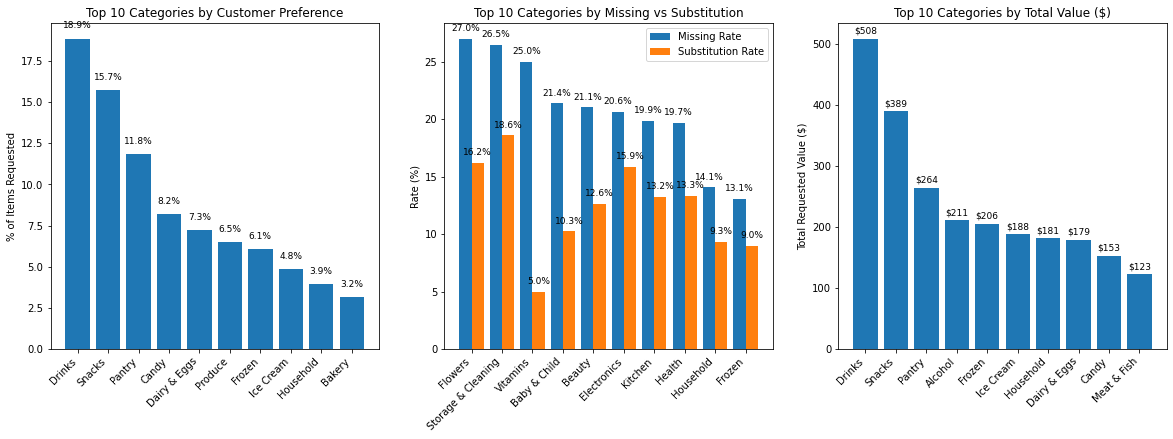

In [41]:
import matplotlib.pyplot as plt
import numpy as np

# --- Step 1: Aggregate by product category (add total value) ---
category_summary = (
    df.groupby("ITEM_CATEGORY")
      .agg(
          items_requested=("WAS_REQUESTED", "sum"),
          items_found=("WAS_FOUND", "sum"),
          items_missing=("WAS_MISSING", "sum"),
          items_subbed=("WAS_SUBBED", "sum"),
          category_value_cents=("ITEM_PRICE_CENTS", "sum")  # total requested value
      )
      .reset_index()
)

# Clean/guard
category_summary["category_value_cents"] = category_summary["category_value_cents"].fillna(0)
category_summary["category_value"] = category_summary["category_value_cents"] / 100.0  # to dollars

# --- Step 2: Compute rates & shares ---
category_summary["found_rate"] = category_summary["items_found"] / category_summary["items_requested"]
category_summary["missing_rate"] = category_summary["items_missing"] / category_summary["items_requested"]
category_summary["substitution_rate"] = category_summary["items_subbed"] / category_summary["items_requested"]

total_items = category_summary["items_requested"].sum()
category_summary["request_share"] = np.where(total_items > 0, category_summary["items_requested"] / total_items * 100, 0.0)

total_value = category_summary["category_value"].sum()
category_summary["value_share"] = np.where(total_value > 0, category_summary["category_value"] / total_value * 100, 0.0)

# --- Step 3: Identify top categories ---
top_pref    = category_summary.sort_values("request_share", ascending=False).head(10)
top_missing = category_summary.sort_values("missing_rate", ascending=False).head(10)
top_value   = category_summary.sort_values("category_value", ascending=False).head(10)

# --- Step 4: Visualization (now 1x3) ---
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# (a) Customer preferences
axes[0].bar(top_pref["ITEM_CATEGORY"], top_pref["request_share"])
axes[0].set_title("Top 10 Categories by Customer Preference")
axes[0].set_ylabel("% of Items Requested")
axes[0].set_xticklabels(top_pref["ITEM_CATEGORY"], rotation=45, ha="right")
for i, v in enumerate(top_pref["request_share"]):
    axes[0].text(i, v + 0.5, f"{v:.1f}%", ha="center", va="bottom", fontsize=9)

# (b) At-risk categories (Missing vs Substitution, grouped)
bar_width = 0.4
x = np.arange(len(top_missing))
axes[1].bar(x - bar_width/2, top_missing["missing_rate"]*100, width=bar_width, label="Missing Rate")
axes[1].bar(x + bar_width/2, top_missing["substitution_rate"]*100, width=bar_width, label="Substitution Rate")
axes[1].set_xticks(x)
axes[1].set_xticklabels(top_missing["ITEM_CATEGORY"], rotation=45, ha="right")
axes[1].set_title("Top 10 Categories by Missing vs Substitution")
axes[1].set_ylabel("Rate (%)")
axes[1].legend()
for i, v in enumerate(top_missing["missing_rate"]*100):
    axes[1].text(i - bar_width/2, v + 0.5, f"{v:.1f}%", ha="center", va="bottom", fontsize=9)
for i, v in enumerate(top_missing["substitution_rate"]*100):
    axes[1].text(i + bar_width/2, v + 0.5, f"{v:.1f}%", ha="center", va="bottom", fontsize=9)

# (c) NEW: Top valuable categories (total requested $, vertical bars)
axes[2].bar(top_value["ITEM_CATEGORY"], top_value["category_value"], color="#1f77b4")

axes[2].set_title("Top 10 Categories by Total Value ($)")
axes[2].set_ylabel("Total Requested Value ($)")
axes[2].set_xticklabels(top_value["ITEM_CATEGORY"], rotation=45, ha="right")

# Add labels on top of bars
for i, v in enumerate(top_value["category_value"]):
    label = f"${v:,.0f}" if v < 10_000 else f"${v/1000:,.1f}k"
    axes[2].text(i, v + (0.01 * top_value["category_value"].max()), label, ha="center", va="bottom", fontsize=9)



/var/folders/3k/cts67njn2xx4fz8j4dfzb0x40000gn/T/ipykernel_5607/1043204311.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(top_pref["ITEM_CATEGORY"], rotation=45, ha="right")


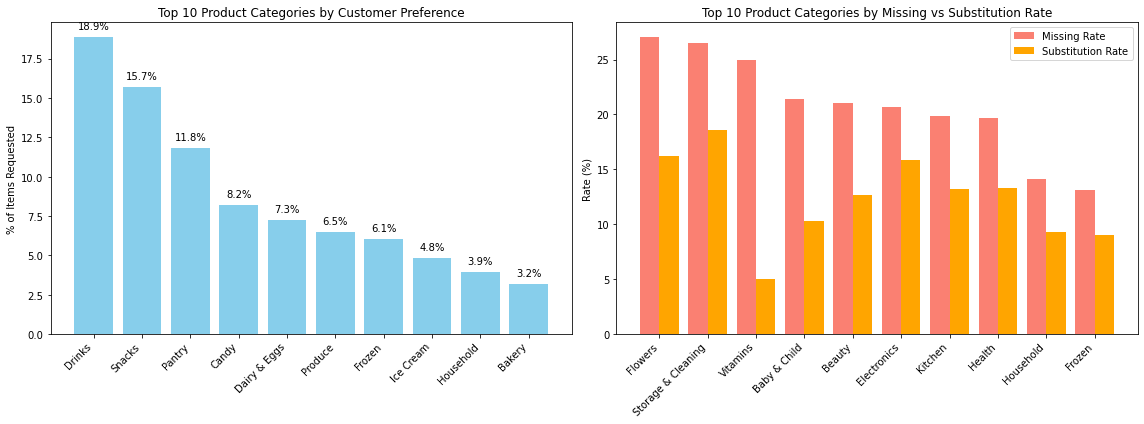

In [65]:
import matplotlib.pyplot as plt

# --- Step 1: Aggregate by product category ---
category_summary = (
    df.groupby("ITEM_CATEGORY")
      .agg(
          items_requested=("WAS_REQUESTED", "sum"),
          items_found=("WAS_FOUND", "sum"),
          items_missing=("WAS_MISSING", "sum"),
          items_subbed=("WAS_SUBBED", "sum")
      )
      .reset_index()
)

# --- Step 2: Compute rates ---
category_summary["found_rate"] = category_summary["items_found"] / category_summary["items_requested"]
category_summary["missing_rate"] = category_summary["items_missing"] / category_summary["items_requested"]
category_summary["substitution_rate"] = category_summary["items_subbed"] / category_summary["items_requested"]

# % of requests = preference
total_items = category_summary["items_requested"].sum()
category_summary["request_share"] = category_summary["items_requested"] / total_items * 100

# --- Step 3: Identify top categories ---
# Top 10 by customer preference
top_pref = category_summary.sort_values("request_share", ascending=False).head(10)

# Top 10 by risk (highest missing_rate)
top_missing = category_summary.sort_values("missing_rate", ascending=False).head(10)

# --- Step 4: Visualization (customer preference vs missing + sub risk) ---
fig, axes = plt.subplots(1, 2, figsize=(16,6))

# (a) Customer preferences (vertical)
axes[0].bar(top_pref["ITEM_CATEGORY"], top_pref["request_share"], color="skyblue")
axes[0].set_title("Top 10 Product Categories by Customer Preference")
axes[0].set_ylabel("% of Items Requested")
axes[0].set_xticklabels(top_pref["ITEM_CATEGORY"], rotation=45, ha="right")
for i, v in enumerate(top_pref["request_share"]):
    axes[0].text(i, v+0.5, f"{v:.1f}%", ha="center")

# (b) At-risk categories (Missing vs Substitution, vertical grouped bars)
bar_width = 0.4
x = range(len(top_missing))

axes[1].bar(
    [i - bar_width/2 for i in x],
    top_missing["missing_rate"]*100,
    width=bar_width,
    color="salmon",
    label="Missing Rate"
)

axes[1].bar(
    [i + bar_width/2 for i in x],
    top_missing["substitution_rate"]*100,
    width=bar_width,
    color="orange",
    label="Substitution Rate"
)

axes[1].set_xticks(x)
axes[1].set_xticklabels(top_missing["ITEM_CATEGORY"], rotation=45, ha="right")
axes[1].set_title("Top 10 Product Categories by Missing vs Substitution Rate")
axes[1].set_ylabel("Rate (%)")
axes[1].legend()

plt.tight_layout()
plt.show()

In [42]:
# Category level
items = df[df["WAS_REQUESTED"] == 1]

In [43]:
item_cat = (
    items.groupby("ITEM_CATEGORY")
         .agg(
             items_requested=("WAS_REQUESTED","sum"),
             items_missing=("WAS_MISSING","sum"),
             items_subbed=("WAS_SUBBED","sum"),
             items_found=("WAS_FOUND","sum"),
             avg_price=("ITEM_PRICE_CENTS","mean")
         )
)
item_cat["missing_rate"] = item_cat["items_missing"] / item_cat["items_requested"]
item_cat["subbed_rate"] = item_cat["items_subbed"] / item_cat["items_requested"]
item_cat = item_cat.sort_values("missing_rate", ascending=False)

item_cat.head(10)


,items_requested,items_missing,items_subbed,items_found,avg_price,missing_rate,subbed_rate
ITEM_CATEGORY,,,,,,,
Flowers,37.0,10.0,6.0,26.0,14.970270,0.270270,0.162162
Storage & Cleaning,102.0,27.0,19.0,75.0,9.956373,0.264706,0.186275
Vitamins,20.0,5.0,1.0,15.0,11.892500,0.250000,0.050000
Baby & Child,341.0,73.0,35.0,266.0,10.082991,0.214076,0.102639
Beauty,95.0,20.0,12.0,74.0,8.740000,0.210526,0.126316
Electronics,63.0,13.0,10.0,49.0,17.198413,0.206349,0.158730
Kitchen,136.0,27.0,18.0,109.0,10.844118,0.198529,0.132353
Health,330.0,65.0,44.0,263.0,10.223333,0.196970,0.133333
Household,2392.0,337.0,223.0,2051.0,7.582312,0.140886,0.093227


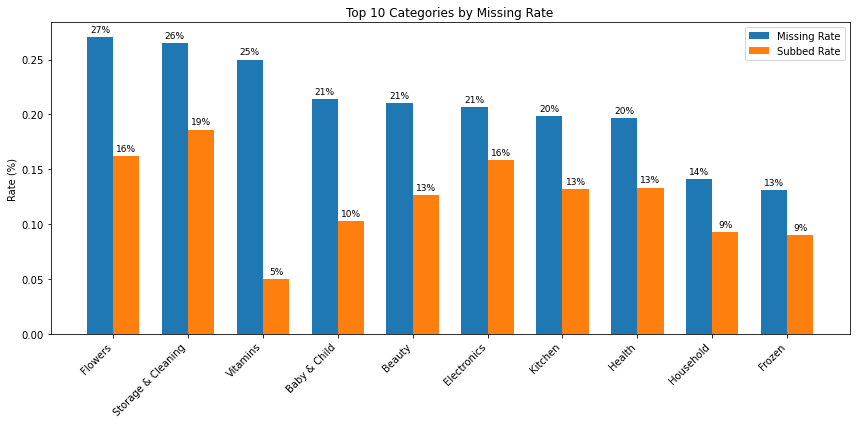

In [44]:
top10 = item_cat.head(10)  # top 10 categories by missing_rate

x = np.arange(len(top10))  # positions
width = 0.35  # bar width

fig, ax = plt.subplots(figsize=(12,6))

# Bars
bars1 = ax.bar(x - width/2, top10["missing_rate"], width, label="Missing Rate")
bars2 = ax.bar(x + width/2, top10["subbed_rate"], width, label="Subbed Rate")

# Add labels
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f"{height:.0%}",   # convert to percentage label
                xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0,3),  # offset above bar
                textcoords="offset points",
                ha="center", va="bottom", fontsize=9)


# Formatting
ax.set_ylabel("Rate (%)")
ax.set_title("Top 10 Categories by Missing Rate")
ax.set_xticks(x)
ax.set_xticklabels(top10.index, rotation=45, ha="right")
ax.legend()

plt.tight_layout()
plt.show()

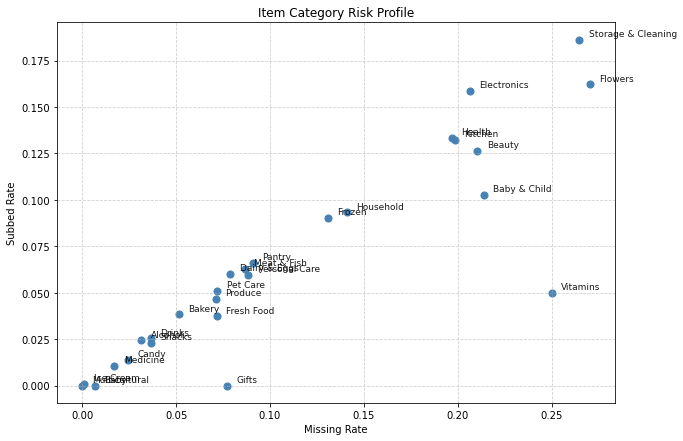

In [45]:
plt.figure(figsize=(10,7))
plt.scatter(item_cat['missing_rate'], item_cat['subbed_rate'], s=50, color="steelblue")

for i, cat in enumerate(item_cat.index):
    plt.text(item_cat['missing_rate'][i]+0.005,   # small horizontal offset
             item_cat['subbed_rate'][i]+0.002,   # small vertical offset
             cat, fontsize=9, alpha=0.9)

plt.xlabel("Missing Rate")
plt.ylabel("Subbed Rate")
plt.title("Item Category Risk Profile")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()